## Version 4999
Getting started with MLflow. This should work now. Have openned nsg for internet

Add autoreload since we are now modifying scripts in other folders.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dotenv import load_dotenv
load_dotenv("/home/lkwasniewski/repos/00001_Studia/MLOPSgradedFinal/.env", override=True)


False

In [3]:
import os
print(os.getenv("AWS_ACCESS_KEY"))  # Should print the key


None


In [4]:
from dotenv import dotenv_values
from pathlib import Path

# Load .env using expanded path
env_path = Path.home() / "repos/00001_Studia/MLOPSgradedFinal/.env"
print(f"Loading environment variables from: {env_path}")
env_vars = dotenv_values(dotenv_path=env_path)  # returns a dict

# Print all loaded env vars
for key, value in env_vars.items():
    print(f"{key} = {value}")


Loading environment variables from: /home/lkwasniewski/repos/00001_Studia/MLOPSgradedFinal/.env


Getting the data.

In [5]:

import os
from pathlib import Path
container_check = os.getenv("iscontainer")
if container_check=="y":
    config_dir = Path("/home/vscode/.config/kaggle")
    config_dir.mkdir(parents=True, exist_ok=True)

    with open(config_dir / "kaggle.json", "w") as dst:
        with open("../kaggle.json", "r") as src:
            dst.write(src.read())

In [6]:

import os
import sys

sys.path.append(os.path.abspath(".."))

from ARISA_DSML.config import RAW_DATA_DIR, categorical, target
from ARISA_DSML.preproc import get_raw_data


2025-06-22 15:36:24.911 | INFO     | ARISA_DSML.config:<module>:13 - PROJ_ROOT path is: /home/lkwasniewski/repos/00001_Studia/MLOPSGradedFinal


In [7]:
from ARISA_DSML.helpers import get_active_branch_name, get_git_commit_hash

get_active_branch_name("..")  # need ".." because we are not in root
get_git_commit_hash()


'821671cc9e53c12923b2de4905db9e9f850f6ff8'

In [8]:
get_raw_data()
!dir "{RAW_DATA_DIR}"

2025-06-22 15:36:25.787 | INFO     | ARISA_DSML.preproc:get_raw_data:20 - RAW_DATA_DIR is: /home/lkwasniewski/repos/00001_Studia/MLOPSGradedFinal/data/raw


Dataset URL: https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database
bots_vs_users.csv  diabetes_new_test.csv  test.csv
diabetes.csv	   diabetes_test.csv


Load preproc from preproc.py and run on train data:

In [9]:
from ARISA_DSML.preproc import preprocess_df

train_path = preprocess_df(RAW_DATA_DIR / "diabetes.csv")

In [10]:
train_path

PosixPath('/home/lkwasniewski/repos/00001_Studia/MLOPSGradedFinal/data/processed/diabetes.csv')

In [11]:
import pandas as pd

df_train = pd.read_csv(train_path)
df_train.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,125.0,33.6,0.627,50,1
1,1,85.0,66.0,29.0,125.0,26.6,0.351,31,0
2,8,183.0,64.0,29.0,125.0,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    float64
 2   BloodPressure             768 non-null    float64
 3   SkinThickness             768 non-null    float64
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 54.1 KB


Split into X and y, get categorical indices:

In [13]:
print(df_train.columns.tolist())

['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']


In [14]:
y_train = df_train.pop(target)
X_train = df_train

#categorical_indices = [X_train.columns.get_loc(col) for col in categorical if col in X_train.columns]
cacategorical = []
categorical_indices = []

And run the hyperparameter optimization (if ):

In [15]:
import mlflow
from ARISA_DSML.train import run_hyperopt, get_or_create_experiment

mlflow.set_tracking_uri(f"http://13.49.221.214:5000/")

experiment_id = get_or_create_experiment("diabetes_hyperparam_tuning_v2")
mlflow.set_experiment(experiment_id=experiment_id)
best_params_path = run_hyperopt(X_train, y_train, categorical_indices)


2025-06-22 15:36:30.373 | INFO     | ARISA_DSML.train:run_hyperopt:82 - Best Parameters: {'depth': 3, 'learning_rate': 0.2847856453953337, 'iterations': 101, 'l2_leaf_reg': 0.08064725446361332, 'bagging_temperature': 0.4441828029429478, 'random_strength': 9.931197047043607}


In [16]:
print([X_train.columns[i] for i in categorical_indices])

[]


Do cross validation again:

In [17]:
import joblib
from ARISA_DSML.train import train_cv
params = joblib.load(best_params_path)
n_folds = 5
cv_output_path = train_cv(X_train, y_train, categorical_indices, params, n=n_folds)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]
0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 59.3ms	remaining: 5.93s
1:	learn: 0.5061728	test: 0.5714286	best: 0.5714286 (1)	total: 67.9ms	remaining: 3.36s
2:	learn: 0.4728435	test: 0.5185185	best: 0.5714286 (1)	total: 74.6ms	remaining: 2.44s
3:	learn: 0.4300341	test: 0.5063291	best: 0.5714286 (1)	total: 79.3ms	remaining: 1.92s
4:	learn: 0.4774194	test: 0.5128205	best: 0.5714286 (1)	total: 83.2ms	remaining: 1.6s
5:	learn: 0.4922118	test: 0.5250000	best: 0.5714286 (1)	total: 86.5ms	remaining: 1.37s
6:	learn: 0.5498489	test: 0.5679012	best: 0.5714286 (1)	total: 103ms	remaining: 1.39s
7:	learn: 0.5481928	test: 0.5679012	best: 0.5714286 (1)	total: 107ms	remaining: 1.24s
8:	learn: 0.5552239	test: 0.5609756	best: 0.5714286 (1)	total: 110ms	remaining: 1.12s
9:	learn: 0.5568862	test: 0.5609756	best: 0.5714286 (1)	total: 112ms	remaining: 1.02s
10:	learn: 0.5780347	test: 0.5882353	best: 0.5882353 (10)	total: 113ms	remaining: 927ms
11:	learn: 0.5786517	tes

And get the performance plots:

In [18]:
from ARISA_DSML.train import plot_error_scatter
cv_results = pd.read_csv(cv_output_path)
plot_error_scatter(
    df_plot=cv_results, 
    name="Mean F1 Score", 
    title="Cross-Validation (N=5) Mean F1 score with Error Bands",
    xtitle="Training Steps",
    ytitle="Performance Score",
    yaxis_range=[0.5, 1]
)

In [19]:
plot_error_scatter(
    cv_results,
    x="iterations",
    y="test-Logloss-mean",
    err="test-Logloss-std",
    name="Mean logloss",
    title="Cross-Validation (N=5) Mean Logloss with Error Bands",
    xtitle="Training Steps",
    ytitle="Logloss",
)


Fit model on full dataset:

In [20]:
from ARISA_DSML.train import train
params = joblib.load(best_params_path)
experiment_id = get_or_create_experiment("diabetes_hyperparam_tuning_v2")
mlflow.set_experiment(experiment_id=experiment_id)
cv_results = pd.read_csv(cv_output_path)
model_path, model_params_path = train(X_train, y_train, categorical_indices, params, cv_results=cv_results)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6612246	total: 4ms	remaining: 400ms
50:	learn: 0.3681974	total: 25.8ms	remaining: 25.3ms
100:	learn: 0.2604910	total: 42.8ms	remaining: 0us


/home/lkwasniewski/repos/00001_Studia/.venv-mlops/lib/python3.11/site-packages/mlflow/types/utils.py:452: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.

Registered model 'diabetes-binary-class' already exists. Creating a new version of this model...
2025/06/22 15:36:40 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish crea

🏃 View run likeable-yak-91 at: http://13.49.221.214:5000/#/experiments/3/runs/b9ed105bea994a3fbf1879d8dc7f0ad5
🧪 View experiment at: http://13.49.221.214:5000/#/experiments/3


And now for the test set, because of our refactor, we don't need to copy paste anymore:

In [21]:
import mlflow
from mlflow.tracking import MlflowClient

print("Tracking URI:", mlflow.get_tracking_uri())

client = MlflowClient()
experiment = client.get_experiment_by_name("diabetes_hyperparam_tuning_v2")

print("Artifact Location:", experiment.artifact_location)

Tracking URI: http://13.49.221.214:5000/
Artifact Location: s3://lknet-mlops-mlflow-artifacts/mlflow/3


In [22]:
from dotenv import load_dotenv
load_dotenv(dotenv_path=".env", override=True)

False

In [23]:
import os
print(os.getenv("ARTIFACT_ROOT"))  # Should print your-access-key

None


In [24]:
dataset_test_path = RAW_DATA_DIR / "test.csv"
preprocced_test_path = preprocess_df(dataset_test_path)
df_test = pd.read_csv(preprocced_test_path)
df_test["Age"].unique()

df_test.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72.0,35.0,131.0,33.6,0.627,50,1
1,1,85,66.0,29.0,131.0,26.6,0.351,31,0
2,8,183,64.0,33.5,131.0,23.3,0.672,32,1
3,1,89,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137,40.0,35.0,168.0,43.1,2.288,33,1


In [25]:
df_train.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148.0,72.0,35.0,125.0,33.6,0.627,50
1,1,85.0,66.0,29.0,125.0,26.6,0.351,31
2,8,183.0,64.0,29.0,125.0,23.3,0.672,32
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33


Get predictions and shap plot:

/tmp/ipykernel_6850/1858435873.py:16: FutureWarning:

``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages



⚠️ Model signature missing or invalid: No signature found in model metadata.
🛠️ Fallback: manually set feature_columns.
✅ Predictions saved to /home/lkwasniewski/repos/00001_Studia/MLOPSGradedFinal/models/preds.csv


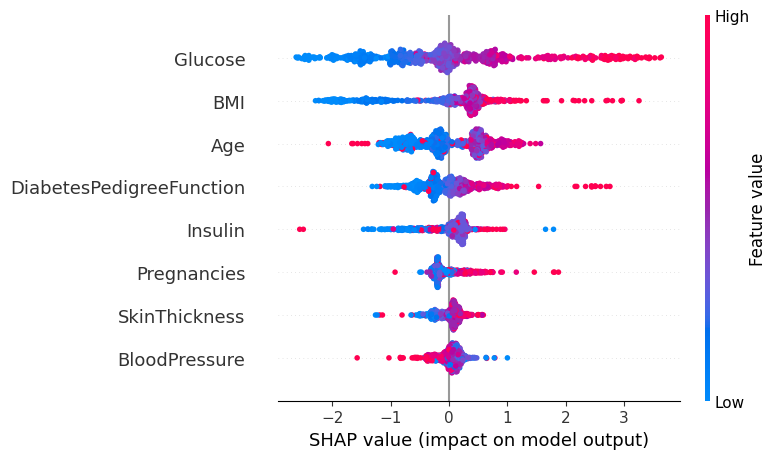

In [26]:
import os
import json
import pandas as pd
import mlflow
from mlflow.client import MlflowClient
import joblib
from ARISA_DSML.predict import predict
from ARISA_DSML.config import PROCESSED_DATA_DIR, MODELS_DIR

# Load diabetes test set
df_test = pd.read_csv(PROCESSED_DATA_DIR / "diabetes.csv")

# Initialize MLflow client and get latest model info
client = MlflowClient(mlflow.get_tracking_uri())
model_name = "diabetes-binary-class"
model_info = client.get_latest_versions(model_name)[0]
run = client.get_run(model_info.run_id)

# Load model
_, artifact_folder = os.path.split(model_info.source)
model_uri = f"runs:/{model_info.run_id}/{artifact_folder}"
loaded_model = mlflow.catboost.load_model(model_uri)

# Load run parameters
run_data_dict = run.data.to_dictionary()
params = run_data_dict.get("params", {})

# Try to extract feature_columns from signature or fallback to model_params.pkl
try:
    log_model_meta = json.loads(run.data.tags.get("mlflow.log-model.history", "[]"))
    signature = log_model_meta[0].get("signature", None)
    if not signature:
        raise ValueError("No signature found in model metadata.")
    inputs = json.loads(signature["inputs"])
    params["feature_columns"] = [inp["name"] for inp in inputs]
    print("✅ Loaded feature_columns from model signature.")
except Exception as e:
    print(f"⚠️ Model signature missing or invalid: {e}")
    params["feature_columns"] = [
        'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
        'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'
    ]
    print("🛠️ Fallback: manually set feature_columns.")

# Run prediction
preds_path = predict(loaded_model, df_test, params, probs=True)
print(f"✅ Predictions saved to {preds_path}")


And that's it for the Mlflow demo.  

In [27]:
print("🧾 df_test.columns:", list(df_test.columns))
print("🔑 Required columns:", params.get("feature_columns"))
print("📦 log_model_meta:", json.dumps(log_model_meta, indent=2))

🧾 df_test.columns: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome', 'predicted_probability', 'prediction']
🔑 Required columns: None
📦 log_model_meta: [
  {
    "run_id": "b9ed105bea994a3fbf1879d8dc7f0ad5",
    "artifact_path": "model",
    "utc_time_created": "2025-06-22 13:36:35.620917",
    "model_uuid": "d35cb9d7fe764e869465d061b9ed232e",
    "flavors": {
      "python_function": {
        "loader_module": "mlflow.catboost",
        "python_version": "3.11.2",
        "data": "model.cb",
        "env": {
          "conda": "conda.yaml",
          "virtualenv": "python_env.yaml"
        }
      },
      "catboost": {
        "catboost_version": "1.2.7",
        "code": null,
        "model_type": "CatBoostClassifier",
        "save_format": "cbm",
        "data": "model.cb"
      }
    }
  }
]


In [28]:
from dotenv import dotenv_values
from pathlib import Path

# Load .env using expanded path
env_path = Path.home() / "repos/00001_Studia/MLOPSgradedFinal/.env"
print(f"Loading environment variables from: {env_path}")
env_vars = dotenv_values(dotenv_path=env_path)  # returns a dict

# Print all loaded env vars
for key, value in env_vars.items():
    print(f"{key} = {value}")


Loading environment variables from: /home/lkwasniewski/repos/00001_Studia/MLOPSgradedFinal/.env


In [29]:
from ARISA_DSML.resolve import get_model_by_alias
client = MlflowClient(mlflow.get_tracking_uri())
champ_mv = get_model_by_alias(client)
chall_mv = get_model_by_alias(client, alias="challenger")

⚠️ Could not extract feature_columns from signature: 'No signature block found.'
🛠️ Fallback: manually assigned feature_columns.
📦 Loading model from: runs:/11fcdc21b4194b2187d0dbbeace7c458/model


✅ Predictions saved to: /home/lkwasniewski/repos/00001_Studia/MLOPSGradedFinal/models/preds.csv


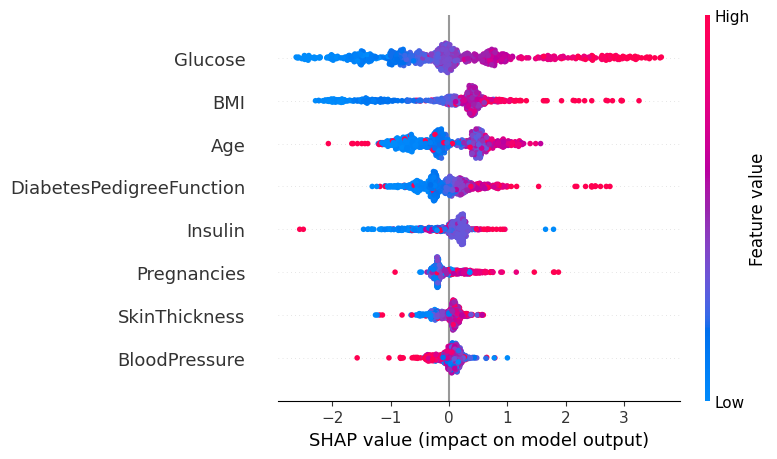

In [30]:
from ARISA_DSML.config import MODEL_NAME

client = MlflowClient(mlflow.get_tracking_uri())
model_info = get_model_by_alias(client, alias="champion")

if model_info is None:
    print("No champion model, predicting using newest model")
    model_info = client.get_latest_versions(MODEL_NAME)[0]

run = client.get_run(model_info.run_id)
run_data_dict = run.data.to_dictionary()

# Try to extract signature safely
params = run_data_dict.get("params", {})

try:
    log_model_meta = json.loads(run.data.tags['mlflow.log-model.history'])
    signature = log_model_meta[0].get("signature")
    if signature:
        inputs = json.loads(signature["inputs"])
        params["feature_columns"] = [inp["name"] for inp in inputs]
        print("✅ Loaded feature_columns from model signature.")
    else:
        raise KeyError("No signature block found.")
except Exception as e:
    print(f"⚠️ Could not extract feature_columns from signature: {e}")
    params["feature_columns"] = [
        'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
        'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'
    ]
    print("🛠️ Fallback: manually assigned feature_columns.")

# Load the model
_, artifact_folder = os.path.split(model_info.source)
model_uri = f"runs:/{model_info.run_id}/{artifact_folder}"
print(f"📦 Loading model from: {model_uri}")
loaded_model = mlflow.catboost.load_model(model_uri)

# Run prediction
preds_path = predict(loaded_model, df_test, params)
print(f"✅ Predictions saved to: {preds_path}")



In [31]:
from mlflow.tracking import MlflowClient

client = MlflowClient()
experiment = client.get_experiment_by_name("diabetes_hyperparam_tuning")
if experiment and experiment.lifecycle_stage == "deleted":
    client.restore_experiment(experiment.experiment_id)
    print("✅ Experiment restored.")

##Adding NannyML


In [32]:
import pandas as pd
import numpy as np

# Number of samples
num_samples = 10

# Generate random but realistic values for each feature
np.random.seed(42)
diabetes_test = pd.DataFrame(
    {
        "Pregnancies": np.random.randint(0, 10, num_samples),
        "Glucose": np.random.randint(80, 200, num_samples),
        "BloodPressure": np.random.randint(60, 100, num_samples),
        "SkinThickness": np.random.randint(15, 50, num_samples),
        "Insulin": np.random.randint(15, 276, num_samples),
        "BMI": np.round(np.random.uniform(18.0, 50.0, num_samples), 1),
        "DiabetesPedigreeFunction": np.round(np.random.uniform(0.1, 2.5, num_samples), 3),
        "Age": np.random.randint(21, 75, num_samples),
        # Optionally include Outcome for labeled test set
        "Outcome": np.random.randint(0, 2, num_samples),
    }
)

# Example: Add a special row with custom values 
new_row = {
    "Pregnancies": 3,
    "Glucose": 120,
    "BloodPressure": 70,
    "SkinThickness": 25,
    "Insulin": 80,
    "BMI": 32.5,
    "DiabetesPedigreeFunction": 0.45,
    "Age": 29,
    "Outcome": 1,  # Set to 0 or 1 as desired; or remove if you want an unlabeled row
}
diabetes_test.loc[len(diabetes_test)] = new_row

# Save as CSV in your preferred directory, e.g. RAW_DATA_DIR
diabetes_test.to_csv(RAW_DATA_DIR / "diabetes_test.csv", index=False)
diabetes_test.to_csv("diabetes_test.csv", index=False)  # For a standalone script

# Display the generated dataset
diabetes_test

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,179,97,29,67,23.9,0.881,27,1
1,3,183,61,17,106,49.0,1.033,29,0
2,7,103,80,21,49,42.8,0.751,44,0
3,4,82,92,35,220,48.1,2.089,21,0
4,6,101,71,23,95,46.6,0.956,64,0
5,9,132,81,32,64,37.1,0.774,28,0
6,2,81,84,18,16,47.5,1.402,44,1
7,6,167,86,39,68,20.8,0.438,31,0
8,7,187,87,28,120,24.3,2.025,71,1
9,4,109,75,23,274,19.4,0.279,37,0


In [33]:
import numpy as np
import pandas as pd
from ARISA_DSML.preproc import preprocess_df

# Paths to your diabetes files. Adjust as needed for your naming conventions.
train_path = preprocess_df(RAW_DATA_DIR / "diabetes.csv")
test_path = preprocess_df(RAW_DATA_DIR / "diabetes_test.csv")
new_test_path = preprocess_df(RAW_DATA_DIR / "diabetes_new_test.csv")

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)
new_test_data = pd.read_csv(new_test_path)

# If you want to remove the label for inference (optional):
if "Outcome" in new_test_data.columns:
    new_test_data = new_test_data.drop(columns=["Outcome"])

In [34]:
print(train_data.columns)

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')


In [35]:
import os

from catboost import CatBoostClassifier
import joblib
import mlflow
import mlflow.sklearn
import nannyml as nml

from ARISA_DSML.train import run_hyperopt

# y_train and X_train prepared from diabetes data (Outcome is target)
y_train = train_data.pop(target)
X_train = train_data

# For diabetes, there are no categorical features
categorical_indices = []

best_params_path = run_hyperopt(X_train, y_train, categorical_indices)
params = joblib.load(best_params_path)

# No ignored_features needed for diabetes dataset
params["ignored_features"] = []

model = CatBoostClassifier(
    **params,
    verbose=True,
)

model.fit(
    X_train,
    y_train,
    verbose_eval=50,
    early_stopping_rounds=50,
    cat_features=[],  # Explicitly pass empty list
    use_best_model=False,
    plot=True,
)

2025-06-22 15:36:46.851 | INFO     | ARISA_DSML.train:run_hyperopt:82 - Best Parameters: {'depth': 3, 'learning_rate': 0.2847856453953337, 'iterations': 101, 'l2_leaf_reg': 0.08064725446361332, 'bagging_temperature': 0.4441828029429478, 'random_strength': 9.931197047043607}


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6612246	total: 1.83ms	remaining: 183ms
50:	learn: 0.3681974	total: 25.2ms	remaining: 24.7ms
100:	learn: 0.2604910	total: 39.7ms	remaining: 0us


In [36]:
reference_df = train_data.copy()
reference_df["prediction"] = model.predict(X_train)
reference_df["predicted_probability"] = [p[1] for p in model.predict_proba(X_train)]
reference_df[target] = y_train
col_names = reference_df.drop(columns=["prediction", target, "predicted_probability"]).columns
col_names


Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')

In [37]:
import nannyml as nml

chunk_size = 50

# For diabetes, use all columns except the prediction columns and the target
feature_columns = X_train.columns  # All columns are features

udc = nml.UnivariateDriftCalculator(
    column_names=feature_columns,
    chunk_size=chunk_size,
)

udc.fit(reference_df.drop(columns=["prediction", target, "predicted_probability"]))

estimator = nml.CBPE(
    problem_type="classification_binary",
    y_pred_proba="predicted_probability",
    y_pred="prediction",
    y_true=target,
    metrics=["roc_auc"],
    chunk_size=chunk_size,
)

estimator = estimator.fit(reference_df)

In [38]:
def nml_analysis(estimator, udc, analysis_df, col_names):
    analysis_df = analysis_df.copy()
    analysis_df["prediction"] = model.predict(analysis_df[col_names])
    analysis_df["predicted_probability"] = [
        p[1] for p in model.predict_proba(analysis_df[col_names])
    ]
    # No 'PassengerId' in diabetes dataset!
    estimated_performance = estimator.estimate(analysis_df)

    figure1 = estimated_performance.plot()

    univariate_drift = udc.calculate(
        analysis_df.drop(columns=["prediction", "predicted_probability"])
    )
    display(analysis_df)
    alert_count_ranker = nml.AlertCountRanker()
    alert_count_ranked_features = alert_count_ranker.rank(univariate_drift)
    display(alert_count_ranked_features)

    plot_col_names = analysis_df.drop(columns=["prediction", "predicted_probability"]).columns
    for p in plot_col_names:
        try:
            figure2 = univariate_drift.filter(column_names=[p]).plot()
            figure2.show()
            figure3 = univariate_drift.filter(period="analysis", column_names=[p]).plot(
                kind="distribution"
            )
            figure3.show()
        except Exception as ex:
            print(f"failed to plot some univariate drift analyses for {p}: {ex}")
    return univariate_drift, estimated_performance

In [39]:
ud, ep = nml_analysis(estimator, udc, test_data, col_names)

/home/lkwasniewski/repos/00001_Studia/.venv-mlops/lib/python3.11/site-packages/nannyml/chunk.py:181: UserWarning:

The resulting number of chunks is too low. Please consider splitting your data in a different way or continue at your own risk.

/home/lkwasniewski/repos/00001_Studia/.venv-mlops/lib/python3.11/site-packages/nannyml/chunk.py:181: UserWarning:

The resulting number of chunks is too low. Please consider splitting your data in a different way or continue at your own risk.



,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,prediction,predicted_probability
0,6,179,97,29,67,23.9,0.881,27,1,0,0.280500
1,3,183,61,17,106,49.0,1.033,29,0,1,0.992143
2,7,103,80,21,49,42.8,0.751,44,0,0,0.351131
3,4,82,92,35,220,48.1,2.089,21,0,1,0.503813
4,6,101,71,23,95,46.6,0.956,64,0,0,0.016992
5,9,132,81,32,64,37.1,0.774,28,0,1,0.525429
6,2,81,84,18,16,47.5,1.402,44,1,0,0.055772
7,6,167,86,39,68,20.8,0.438,31,0,0,0.375437
8,7,187,87,28,120,24.3,2.025,71,1,0,0.106311
9,4,109,75,23,274,19.4,0.279,37,0,0,0.042565


,number_of_alerts,column_name,rank
0,1,SkinThickness,1
1,1,Pregnancies,2
2,1,Insulin,3
3,1,Glucose,4
4,1,DiabetesPedigreeFunction,5
5,1,BloodPressure,6
6,1,BMI,7
7,1,Age,8


/home/lkwasniewski/repos/00001_Studia/.venv-mlops/lib/python3.11/site-packages/nannyml/chunk.py:181: UserWarning:

The resulting number of chunks is too low. Please consider splitting your data in a different way or continue at your own risk.



/home/lkwasniewski/repos/00001_Studia/.venv-mlops/lib/python3.11/site-packages/nannyml/chunk.py:181: UserWarning:

The resulting number of chunks is too low. Please consider splitting your data in a different way or continue at your own risk.



/home/lkwasniewski/repos/00001_Studia/.venv-mlops/lib/python3.11/site-packages/nannyml/chunk.py:181: UserWarning:

The resulting number of chunks is too low. Please consider splitting your data in a different way or continue at your own risk.



/home/lkwasniewski/repos/00001_Studia/.venv-mlops/lib/python3.11/site-packages/nannyml/chunk.py:181: UserWarning:

The resulting number of chunks is too low. Please consider splitting your data in a different way or continue at your own risk.



/home/lkwasniewski/repos/00001_Studia/.venv-mlops/lib/python3.11/site-packages/nannyml/chunk.py:181: UserWarning:

The resulting number of chunks is too low. Please consider splitting your data in a different way or continue at your own risk.



/home/lkwasniewski/repos/00001_Studia/.venv-mlops/lib/python3.11/site-packages/nannyml/chunk.py:181: UserWarning:

The resulting number of chunks is too low. Please consider splitting your data in a different way or continue at your own risk.



/home/lkwasniewski/repos/00001_Studia/.venv-mlops/lib/python3.11/site-packages/nannyml/chunk.py:181: UserWarning:

The resulting number of chunks is too low. Please consider splitting your data in a different way or continue at your own risk.



/home/lkwasniewski/repos/00001_Studia/.venv-mlops/lib/python3.11/site-packages/nannyml/chunk.py:181: UserWarning:

The resulting number of chunks is too low. Please consider splitting your data in a different way or continue at your own risk.



failed to plot some univariate drift analyses for Outcome: could not read result data: 'Outcome'


In [40]:
ud, ep = nml_analysis(estimator, udc, new_test_data, col_names)

/home/lkwasniewski/repos/00001_Studia/.venv-mlops/lib/python3.11/site-packages/nannyml/chunk.py:181: UserWarning:

The resulting number of chunks is too low. Please consider splitting your data in a different way or continue at your own risk.

/home/lkwasniewski/repos/00001_Studia/.venv-mlops/lib/python3.11/site-packages/nannyml/chunk.py:181: UserWarning:

The resulting number of chunks is too low. Please consider splitting your data in a different way or continue at your own risk.



,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,prediction,predicted_probability
0,6,179,97,29,67,23.9,0.881,27,0,0.280500
1,3,183,61,17,106,49.0,1.033,29,1,0.992143
2,7,103,80,21,49,42.8,0.751,44,0,0.351131
3,4,82,92,35,220,48.1,2.089,21,1,0.503813
4,6,101,71,23,95,46.6,0.956,64,0,0.016992
5,9,132,81,32,64,37.1,0.774,28,1,0.525429
6,2,81,84,18,16,47.5,1.402,44,0,0.055772
7,6,167,86,39,68,20.8,0.438,31,0,0.375437
8,7,187,87,28,120,24.3,2.025,71,0,0.106311
9,4,109,75,23,274,19.4,0.279,37,0,0.042565


,number_of_alerts,column_name,rank
0,1,SkinThickness,1
1,1,Pregnancies,2
2,1,Insulin,3
3,1,Glucose,4
4,1,DiabetesPedigreeFunction,5
5,1,BloodPressure,6
6,1,BMI,7
7,1,Age,8


/home/lkwasniewski/repos/00001_Studia/.venv-mlops/lib/python3.11/site-packages/nannyml/chunk.py:181: UserWarning:

The resulting number of chunks is too low. Please consider splitting your data in a different way or continue at your own risk.



/home/lkwasniewski/repos/00001_Studia/.venv-mlops/lib/python3.11/site-packages/nannyml/chunk.py:181: UserWarning:

The resulting number of chunks is too low. Please consider splitting your data in a different way or continue at your own risk.



/home/lkwasniewski/repos/00001_Studia/.venv-mlops/lib/python3.11/site-packages/nannyml/chunk.py:181: UserWarning:

The resulting number of chunks is too low. Please consider splitting your data in a different way or continue at your own risk.



/home/lkwasniewski/repos/00001_Studia/.venv-mlops/lib/python3.11/site-packages/nannyml/chunk.py:181: UserWarning:

The resulting number of chunks is too low. Please consider splitting your data in a different way or continue at your own risk.



/home/lkwasniewski/repos/00001_Studia/.venv-mlops/lib/python3.11/site-packages/nannyml/chunk.py:181: UserWarning:

The resulting number of chunks is too low. Please consider splitting your data in a different way or continue at your own risk.



/home/lkwasniewski/repos/00001_Studia/.venv-mlops/lib/python3.11/site-packages/nannyml/chunk.py:181: UserWarning:

The resulting number of chunks is too low. Please consider splitting your data in a different way or continue at your own risk.



/home/lkwasniewski/repos/00001_Studia/.venv-mlops/lib/python3.11/site-packages/nannyml/chunk.py:181: UserWarning:

The resulting number of chunks is too low. Please consider splitting your data in a different way or continue at your own risk.



/home/lkwasniewski/repos/00001_Studia/.venv-mlops/lib/python3.11/site-packages/nannyml/chunk.py:181: UserWarning:

The resulting number of chunks is too low. Please consider splitting your data in a different way or continue at your own risk.

